In [ ]:
!pip install datasets transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 17.9 MB/s eta 0:00:00


In [ ]:
import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer

from datasets import load_dataset,concatenate_datasets, load_metric
import pandas as pd
import numpy as np

In [ ]:
wnut = load_dataset("wnut_17")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3394 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1009 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1287 [00:00<?, ? examples/s]

Dataset wnut_17 downloaded and prepared to /root/.cache/huggingface/datasets/wnut_17/wnut_17/1.0.0/077c7f08b8dbc800692e8c9186cdf3606d5849ab0e7be662e6135bb10eba54f9. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
wnut

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 3394
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1009
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1287
    })
})

In [ ]:
label_list = wnut["train"].features[f"ner_tags"].feature.names
id2tag = {id: tag for id, tag in enumerate(label_list)}
id2tag

{0: 'O',
 1: 'B-corporation',
 2: 'I-corporation',
 3: 'B-creative-work',
 4: 'I-creative-work',
 5: 'B-group',
 6: 'I-group',
 7: 'B-location',
 8: 'I-location',
 9: 'B-person',
 10: 'I-person',
 11: 'B-product',
 12: 'I-product'}

In [ ]:
# merge train & validation sets
from datasets import concatenate_datasets

train_dataset = concatenate_datasets([wnut["train"],wnut["validation"]])
train_dataset

Dataset({
    features: ['id', 'tokens', 'ner_tags'],
    num_rows: 4403
})

In [ ]:
ith_example=2

print(wnut["train"][ith_example]['tokens'])
print([id2tag[label] for label in train_dataset[ith_example]['ner_tags']])

['Pxleyes', 'Top', '50', 'Photography', 'Contest', 'Pictures', 'of', 'August', '2010', '...', 'http://bit.ly/bgCyZ0', '#photography']
['B-corporation', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
tokenized_input = tokenizer(wnut["train"][2]["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

In [ ]:
#input
print(wnut["train"][2]["tokens"])

['Pxleyes', 'Top', '50', 'Photography', 'Contest', 'Pictures', 'of', 'August', '2010', '...', 'http://bit.ly/bgCyZ0', '#photography']


In [ ]:
#tokenized
print(tokens)

['[CLS]', 'p', '##xley', '##es', 'top', '50', 'photography', 'contest', 'pictures', 'of', 'august', '2010', '.', '.', '.', 'http', ':', '/', '/', 'bit', '.', 'l', '##y', '/', 'b', '##gc', '##y', '##z', '##0', '#', 'photography', '[SEP]']


In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_wnut = wnut.map(tokenize_and_align_labels, batched=True)
tokenized_train_dataset = train_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/3394 [00:00<?, ? examples/s]

Map:   0%|          | 0/1009 [00:00<?, ? examples/s]

Map:   0%|          | 0/1287 [00:00<?, ? examples/s]

Map:   0%|          | 0/4403 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_dataset[0]

{'id': '0',
 'tokens': ['@paulwalk',
  'It',
  "'s",
  'the',
  'view',
  'from',
  'where',
  'I',
  "'m",
  'living',
  'for',
  'two',
  'weeks',
  '.',
  'Empire',
  'State',
  'Building',
  '=',
  'ESB',
  '.',
  'Pretty',
  'bad',
  'storm',
  'here',
  'last',
  'evening',
  '.'],
 'ner_tags': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  7,
  8,
  8,
  0,
  7,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'input_ids': [101,
  1030,
  2703,
  17122,
  2009,
  1005,
  1055,
  1996,
  3193,
  2013,
  2073,
  1045,
  1005,
  1049,
  2542,
  2005,
  2048,
  3134,
  1012,
  3400,
  2110,
  2311,
  1027,
  9686,
  2497,
  1012,
  3492,
  2919,
  4040,
  2182,
  2197,
  3944,
  1012,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
 

In [ ]:
id2tag[-100]='ignore'
exml=tokenized_train_dataset[2]

pd.DataFrame({'tokens':tokenizer.convert_ids_to_tokens(exml["input_ids"]), 'ner_labels':exml['labels'], 'ner_tags': [id2tag[label] for label in exml['labels']] })

,tokens,ner_labels,ner_tags
0,[CLS],-100,ignore
1,p,1,B-corporation
2,##xley,-100,ignore
3,##es,-100,ignore
4,top,0,O
5,50,0,O
6,photography,0,O
7,contest,0,O
8,pictures,0,O
9,of,0,O


In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(pd.Series(tokenized_train_dataset['input_ids']).explode(), pd.Series(tokenized_train_dataset['labels']).explode().astype(str))
dummy_clf.score(pd.Series(tokenized_train_dataset['input_ids']).explode(), pd.Series(tokenized_train_dataset['labels']).explode().astype(str))

0.5888494815191806

In [ ]:
exploded_values=pd.Series(tokenized_train_dataset['labels']).explode()
exploded_values=pd.DataFrame(exploded_values,columns=['B'])

most_frequent_elem_by_doc=pd.Series(tokenized_train_dataset['labels']).apply(lambda x:  max(set(x), key=x.count))
most_frequent_elem_by_doc=pd.DataFrame(most_frequent_elem_by_doc,columns=list('A'))

df_most_freq_token=exploded_values.merge(most_frequent_elem_by_doc, how='right', left_index=True, right_index=True)

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(pd.Series(tokenized_train_dataset['input_ids']).explode(), df_most_freq_token['A'])
dummy_clf.score(pd.Series(tokenized_train_dataset['input_ids']).explode(), df_most_freq_token['A'])

0.7197897448947134

In [ ]:
#Data Collator

from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_list))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [ ]:
!pip install seqeval --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
metric_seqeval = load_metric("seqeval")
example = wnut["train"][2]

labels = [label_list[i] for i in example["ner_tags"]]
metric_seqeval.compute(predictions=[labels], references=[labels])

{'corporation': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric_seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir='./log_results',
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=16,   
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    warmup_steps=500, 
    eval_steps=60,
    save_steps=60,
    evaluation_strategy="steps",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_wnut["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 6)]
)

trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
60,No log,1.632616,0.005900,0.005561,0.005725,0.883502
120,No log,0.454912,0.000000,0.000000,0.000000,0.925612
180,No log,0.335237,0.500000,0.001854,0.003693,0.925698
240,No log,0.307291,0.358621,0.192771,0.250753,0.934334
300,No log,0.308024,0.512931,0.220575,0.308490,0.937797
360,No log,0.267296,0.392015,0.400371,0.396149,0.937497
420,No log,0.246316,0.489722,0.375348,0.424974,0.943397
480,No log,0.244409,0.510932,0.411492,0.455852,0.944680
540,0.490400,0.238780,0.543276,0.378128,0.445902,0.946133
600,0.490400,0.266097,0.564474,0.397590,0.466558,0.948442


/usr/local/lib/python3.9/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-d

TrainOutput(global_step=900, training_loss=0.3085180706448025, metrics={'train_runtime': 493.1273, 'train_samples_per_second': 44.644, 'train_steps_per_second': 2.798, 'total_flos': 381625627721310.0, 'train_loss': 0.3085180706448025, 'epoch': 3.26})

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_wnut["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric_seqeval.compute(predictions=true_predictions, references=true_labels)
results

{'corporation': {'precision': 0.19607843137254902,
  'recall': 0.30303030303030304,
  'f1': 0.23809523809523808,
  'number': 66},
 'creative-work': {'precision': 0.43103448275862066,
  'recall': 0.176056338028169,
  'f1': 0.25,
  'number': 142},
 'group': {'precision': 0.38095238095238093,
  'recall': 0.048484848484848485,
  'f1': 0.08602150537634409,
  'number': 165},
 'location': {'precision': 0.4943181818181818,
  'recall': 0.58,
  'f1': 0.5337423312883436,
  'number': 150},
 'person': {'precision': 0.7331460674157303,
  'recall': 0.6083916083916084,
  'f1': 0.664968152866242,
  'number': 429},
 'product': {'precision': 0.18421052631578946,
  'recall': 0.05511811023622047,
  'f1': 0.08484848484848485,
  'number': 127},
 'overall_precision': 0.5432756324900133,
 'overall_recall': 0.37812789620018533,
 'overall_f1': 0.44590163934426225,
 'overall_accuracy': 0.9461331281262024}

In [ ]:
trainer.evaluate()

{'eval_loss': 0.2387797087430954,
 'eval_precision': 0.5432756324900133,
 'eval_recall': 0.37812789620018533,
 'eval_f1': 0.44590163934426225,
 'eval_accuracy': 0.9461331281262024,
 'eval_runtime': 9.838,
 'eval_samples_per_second': 130.819,
 'eval_steps_per_second': 2.135,
 'epoch': 3.26}

In [ ]:
def tag_sentence(text:str):
    # convert our text to a  tokenized sequence
    inputs = tokenizer(text, truncation=True, return_tensors="pt").to("cuda")
    # get outputs
    outputs = model(**inputs)
    # convert to probabilities with softmax
    probs = outputs[0][0].softmax(1)
    # get the tags with the highest probability
    word_tags = [(tokenizer.decode(inputs['input_ids'][0][i].item()), id2tag[tagid.item()]) 
                  for i, tagid in enumerate (probs.argmax(axis=1))]

    return pd.DataFrame(word_tags, columns=['word', 'tag'])

In [ ]:
text = """Narmada and tourists from United States are 
flooding into Greece. But a harsh winter isn’t far off @gmail.com"""

print(tag_sentence(text))

        word            tag
0      [CLS]              O
1         na       B-person
2      ##rma       B-person
3       ##da       B-person
4        and              O
5   tourists              O
6       from              O
7     united     B-location
8     states     B-location
9        are              O
10  flooding              O
11      into              O
12    greece     B-location
13         .              O
14       but              O
15         a              O
16     harsh              O
17    winter              O
18       isn              O
19         ’              O
20         t              O
21       far              O
22       off              O
23         @              O
24       gma  B-corporation
25      ##il              O
26         .              O
27       com              O
28     [SEP]              O


In [ ]:
import pickle

In [ ]:
pickle.dump(model, open("model.pkl", "wb"))
pickle.dump(tokenizer, open("tokenizer.pkl", "wb"))

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from numpy.random import seed
from itertools import chain
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional

plt.style.use('seaborn')

In [ ]:
# getting the data
file = "/content/ner_dataset.csv"
data = pd.read_csv(file, encoding = "latin1")

# drop the POS column because we dont need it
data = data.drop('POS', 1)

In [ ]:
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O


In [ ]:
data = data.fillna(method = 'ffill')

In [ ]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

print(f"Total number of unique words in dataset: {num_words}")

Total number of unique words in dataset: 35179


In [ ]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)
num_tags
print("List of tags: " + ', '.join([tag for tag in tags]))
print(f"Total Number of tags {num_tags}")

List of tags: I-geo, B-per, B-eve, I-org, I-tim, I-per, B-gpe, B-org, B-tim, I-art, I-gpe, B-nat, B-art, O, B-geo, I-nat, I-eve
Total Number of tags 17


In [ ]:
tags

['I-geo',
 'B-per',
 'B-eve',
 'I-org',
 'I-tim',
 'I-per',
 'B-gpe',
 'B-org',
 'B-tim',
 'I-art',
 'I-gpe',
 'B-nat',
 'B-art',
 'O',
 'B-geo',
 'I-nat',
 'I-eve']

In [ ]:
class Get_sentence(object):
    def __init__(self,data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s:[(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                    s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = Get_sentence(data)
sentence = getter.sentences
sentence[10]

[('In', 'O'),
 ('Beirut', 'B-geo'),
 (',', 'O'),
 ('a', 'O'),
 ('string', 'O'),
 ('of', 'O'),
 ('officials', 'O'),
 ('voiced', 'O'),
 ('their', 'O'),
 ('anger', 'O'),
 (',', 'O'),
 ('while', 'O'),
 ('at', 'O'),
 ('the', 'O'),
 ('United', 'B-org'),
 ('Nations', 'I-org'),
 ('summit', 'O'),
 ('in', 'O'),
 ('New', 'B-geo'),
 ('York', 'I-geo'),
 (',', 'O'),
 ('Prime', 'B-per'),
 ('Minister', 'O'),
 ('Fouad', 'B-per'),
 ('Siniora', 'I-per'),
 ('said', 'O'),
 ('the', 'O'),
 ('Lebanese', 'B-gpe'),
 ('people', 'O'),
 ('are', 'O'),
 ('resolute', 'O'),
 ('in', 'O'),
 ('preventing', 'O'),
 ('such', 'O'),
 ('attempts', 'O'),
 ('from', 'O'),
 ('destroying', 'O'),
 ('their', 'O'),
 ('spirit', 'O'),
 ('.', 'O')]

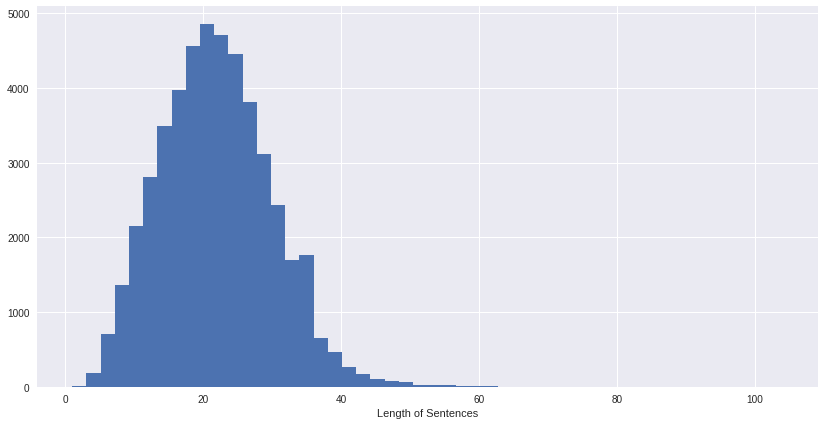

In [ ]:
plt.figure(figsize=(14,7))
plt.hist([len(s) for s in sentence],bins = 50)
plt.xlabel("Length of Sentences")
plt.show()

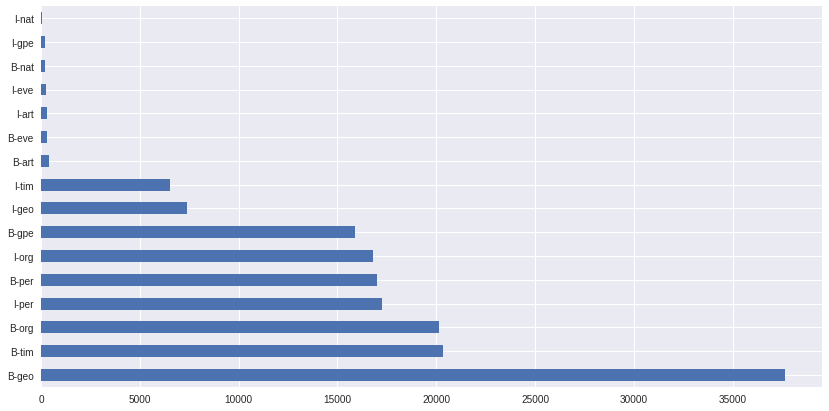

In [ ]:
plt.figure(figsize=(14, 7))
data.Tag[data.Tag != 'O']\
    .value_counts()\
    .plot\
    .barh();

In [ ]:
word_idx = {w : i + 1 for i ,w in enumerate(words)}
tag_idx =  {t : i for i ,t in enumerate(tags)}

In [ ]:
tag_idx

{'I-geo': 0,
 'B-per': 1,
 'B-eve': 2,
 'I-org': 3,
 'I-tim': 4,
 'I-per': 5,
 'B-gpe': 6,
 'B-org': 7,
 'B-tim': 8,
 'I-art': 9,
 'I-gpe': 10,
 'B-nat': 11,
 'B-art': 12,
 'O': 13,
 'B-geo': 14,
 'I-nat': 15,
 'I-eve': 16}

In [ ]:
word_idx

{'Neil': 1,
 'attorney': 2,
 'Qaisar': 3,
 'have': 4,
 'Kovalchuk': 5,
 'blower': 6,
 'shopkeeper': 7,
 'Agca': 8,
 'attorneys': 9,
 'persecuted': 10,
 '23': 11,
 'Asefi': 12,
 'spouses': 13,
 '2.5': 14,
 'hide': 15,
 'societies': 16,
 'Ratner': 17,
 '1910': 18,
 'importing': 19,
 'confessed': 20,
 'lead': 21,
 'thanking': 22,
 'Charm': 23,
 'Manhattan': 24,
 '203': 25,
 'Ronit': 26,
 'abducted': 27,
 'Committees': 28,
 'freest': 29,
 'populated': 30,
 'ounce': 31,
 'breath': 32,
 'Planning': 33,
 'Nigerla': 34,
 'Wikipedia': 35,
 'Colosseum': 36,
 'feet': 37,
 '68-year-old': 38,
 'spectators': 39,
 'celebrated': 40,
 'well-trained': 41,
 'Airtour': 42,
 'Call': 43,
 'Kohl': 44,
 'nickel': 45,
 'frequented': 46,
 'writing': 47,
 'Presidents': 48,
 'truckers': 49,
 'remarks': 50,
 'preaching': 51,
 'out-of-competition': 52,
 'three-hour': 53,
 '787s': 54,
 'Studio': 55,
 'scarcity': 56,
 'Gamal': 57,
 'kingdoms': 58,
 'post-genocide': 59,
 'violate': 60,
 'al-Dulaimi': 61,
 'tests': 62,

In [ ]:
max_len = 50
X = [[word_idx[w[0]] for w in s] for s in sentence]
X = pad_sequences(maxlen = max_len, sequences = X, padding = 'post', value = num_words - 1)

y = [[tag_idx[w[1]] for w in s] for s in sentence]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag_idx['O'])
y = [to_categorical(i, num_classes = num_tags) for i in  y]

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X, y,test_size = 0.1, random_state = 1)

In [ ]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units = 100,return_sequences = True, recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_tags,activation = 'softmax'))(model)
model = Model(input_word,out)

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

In [ ]:
model.fit(x_train, np.array(y_train), batch_size = 64, verbose = 1, epochs = 5, validation_split = 0.2)

Epoch 1/5
540/540 [==============================] - 487s 878ms/step - loss: 0.2744 - accuracy: 0.9422 - val_loss: 0.1227 - val_accuracy: 0.9652
Epoch 2/5
540/540 [==============================] - 454s 841ms/step - loss: 0.0784 - accuracy: 0.9780 - val_loss: 0.0603 - val_accuracy: 0.9825
Epoch 3/5
540/540 [==============================] - 434s 805ms/step - loss: 0.0478 - accuracy: 0.9860 - val_loss: 0.0525 - val_accuracy: 0.9842
Epoch 4/5
540/540 [==============================] - 453s 839ms/step - loss: 0.0380 - accuracy: 0.9884 - val_loss: 0.0499 - val_accuracy: 0.9850
Epoch 5/5
540/540 [==============================] - 439s 814ms/step - loss: 0.0322 - accuracy: 0.9900 - val_loss: 0.0491 - val_accuracy: 0.9854


In [ ]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 11s 75ms/step - loss: 0.0506 - accuracy: 0.9854


[0.05055736377835274, 0.9853878021240234]

In [ ]:
rand_sent = np.random.randint(0, x_test.shape[0]) # get a random sentense
p = model.predict(np.array([x_test[rand_sent]]))
p = np.argmax(p, axis = -1)

y_true = np.argmax(np.array(y_test), axis = -1)[rand_sent] # get actual tags for random sentense

print("{:20}{:20}\t{}\n".format("Word", "True", "Pred"))
print("-" * 55)

for (w, t, pred) in zip(x_test[rand_sent], y_true, p[0]):
    print("{:20}{:20}\t{}".format(words[w - 1], tags[t], tags[pred]))

1/1 [==============================] - 1s 1s/step
Word                True                	Pred

-------------------------------------------------------
Police              O                   	O
arrested            O                   	O
three               O                   	O
of                  O                   	O
the                 O                   	O
suspects            O                   	O
in                  O                   	O
Mumbai              B-geo               	B-geo
and                 O                   	O
the                 O                   	O
fourth              O                   	O
in                  O                   	O
the                 O                   	O
eastern             O                   	O
city                O                   	O
of                  O                   	O
Calcutta            B-geo               	B-geo
.                   O                   	O
Frequent            O                   	O
Frequent            O 

In [ ]:
def create_test_input_from_text(text):
    word_list = text.split(" ")
    x_new = []
    for word in word_list:
        x_new.append(word_idx[word])
        
    p = model.predict(np.array([x_new]))
    p = np.argmax(p, axis = -1)
    print("{:20}\t{}\n".format("Word", "Prediction"))
    print("-" * 35)

    for (w, pred) in zip(range(len(x_new)), p[0]):
        print("{:20}\t{}".format(word_list[w], tags[pred]))

In [ ]:
test_inputs = "the weather in London is very hot"
create_test_input_from_text(test_inputs)

ValueError: ignored

In [ ]:
model.save("second.h5")

In [ ]:
pickle.dump(word_idx, open("word_idx.pkl", "wb"))